In [1]:
from pfp_stat import *

import numpy as np
import pandas as pd 

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib

import datetime as dat

from pylab import title, figure, xlabel, ylabel, xticks, bar, legend, axis, savefig
from fpdf import FPDF
import fpdf

from pfp_products import *

import os.path
from scipy.optimize import minimize

In [2]:
print('Okay, lets see what we have here.')

prodcat_filename = 'inputs/prod_cat open.xlsx'
prodcat_sheetname = 'prod cat'

xls = pd.read_excel(prodcat_filename, prodcat_sheetname, 
                         decimal = '.', usecols = 'b:z', 
                         index_col = 0, header = 1)

print('I`m using `' + prodcat_sheetname + '` sheet of `' + prodcat_filename + '` file as product catalog.')

products = xls.transpose()
all_BAs = []
prod_list = []
max_term = 0

for prod, row in products.iterrows():
    
    check = check_stat(row.BAs)
    
    if check:        
        all_BAs.extend(row.BAs.split(', '))
        all_BAs = list(set(all_BAs))
        
        if row.term > max_term: max_term = row.term

        Note1 = Structure(prod, row.BAs, row.notional_curr, row.term, 
                  row.coupon_value, row.coupon_always, row.coupon_check_months, row.coupon_memory, 
                  row.coupon_lower_barrier, row.coupon_upper_barrier,
                  row.autocall_flag, row.autocall_check_months, row.autocall_barrier, row.autocall_barrier_increase_rate,
                  row.redemption_amount, row.redemption_put_strike, row.redemption_guarantee_rule,
                  row.redemption_upside_participation, row.redemption_downside_participation, row.issuer)
        Note1.stats_ok = True
        
        prod_list.append(Note1)
    else: 
        print ('We dont have enough statistics for ' + row.name + ' underlyings. We do not calculate it now.')

print('...')
print('All products from `prod cat.xls` except mentioned above are successfully loaded.')

Okay, lets see what we have here.
I`m using `prod cat` sheet of `inputs/prod_cat open.xlsx` file as product catalog.
...
All products from `prod cat.xls` except mentioned above are successfully loaded.


In [3]:
n_scenarios = 50000
simulation_years = max_term   

returns = ba_scenarios(all_BAs, 
                       simulation_years,  
                       n_scenarios, 
                       print_statistics = True)

Returns: 
moex rx equity    0.080
open pif          0.120
gmkn rx equity    0.080
solecmvt index    0.020
yndx rx equity    0.120
rog sw equity     0.034
alrs rx equity    0.087
mtss rx equity    0.092
Name: r, dtype: float64
 
Sigmas: 
moex rx equity    0.213164
open pif          0.143242
gmkn rx equity    0.191840
solecmvt index    0.096891
yndx rx equity    0.323618
rog sw equity     0.156097
alrs rx equity    0.278227
mtss rx equity    0.249655
dtype: float32
 
Correlations: 

                moex rx equity  open pif  gmkn rx equity  solecmvt index  \
moex rx equity        1.000000  0.670502        0.276289        0.302035   
open pif              0.670502  1.000000        0.406332        0.074107   
gmkn rx equity        0.276289  0.406332        1.000000        0.291811   
solecmvt index        0.302035  0.074107        0.291811        1.000000   
yndx rx equity        0.525695  0.620546        0.013790        0.099164   
rog sw equity         0.031895  0.094408       -0.124118  

In [4]:
flag = 1
for prod in prod_list:
    
    print('calculating ' + prod.name)
    a1 = prod.payoff(all_BAs, returns, True)
    x = a1.std()
    y = a1.mean()

    if flag == 1:
        flag = 0
        payoffs = a1  
        points = [x, y]
        names = [prod.name]
    else:
        payoffs = np.c_[payoffs, a1]
        points = np.c_[points, [x, y]]
        names.append(prod.name)
print('Done!')

calculating GMKN AM
calculating Rosche AM
calculating Basket coupon
calculating Open PIF
calculating Solars
Done!


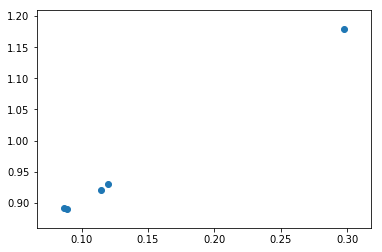

In [5]:
# посмотрим продукты на плоскости риск-доходность:

plt.scatter(points[0,:], points[1,:])
plt.show()

In [6]:
# Определяем функции доходности (веса * среднюю дохдность) и риска (стандартное отклонение результата портфеля):

def return_forecast(wghts):
    return float(((payoffs*wghts).sum(axis = 1).mean()))

def func(wghts):
    ff1 = (payoffs*wghts).sum(axis = 1)
    return -(ff1.mean())/(ff1.std())

In [7]:
# задаем ограничения на веса:
cons = ({'type': 'eq', 'fun' : lambda x: x.sum()-1},
        {'type': 'ineq','fun' : lambda x: 1 - x.max()},
        {'type': 'ineq','fun' : lambda x: x.min()})

# начальные значения весов (всех продуктов поровну)
x0 = np.ones(payoffs.shape[-1])/payoffs.shape[-1]
res = minimize(func, x0, method='SLSQP', options={'disp': True}, constraints=cons)

print('weights:')
print(res.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -16.59766836655076
            Iterations: 8
            Function evaluations: 69
            Gradient evaluations: 8
weights:
[1.77612465e-01 3.82582416e-01 1.42575758e-01 3.30681663e-18
 2.97229361e-01]


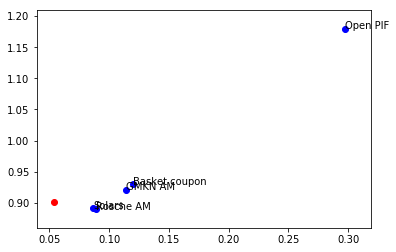

In [8]:
plt.scatter(points[0,:], points[1,:], c='blue')
plt.scatter(((payoffs*res.x).sum(axis = 1)).std(), ((payoffs*res.x).sum(axis = 1)).mean(), c='red')

for i, txt in enumerate(names):
    plt.annotate(txt, (points[0,i], points[1,i]))
plt.show()

GMKN AM


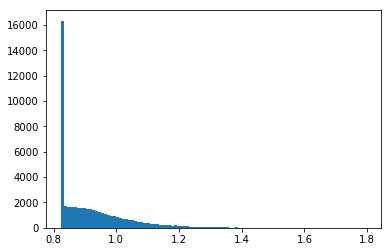

Rosche AM


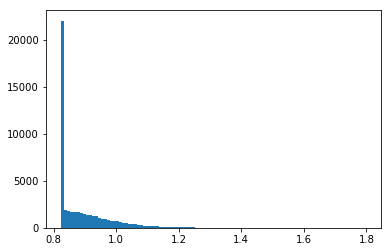

Basket coupon


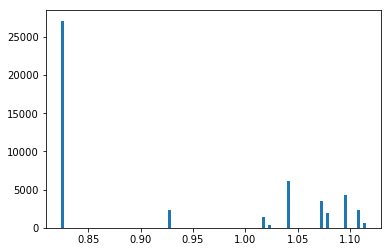

Open PIF


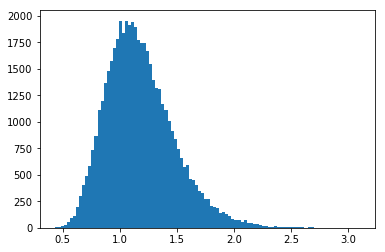

Solars


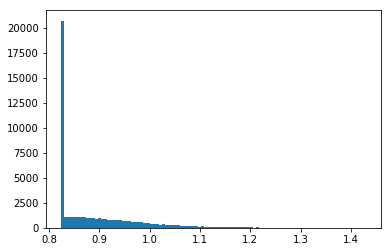

In [9]:
for j in range(payoffs.shape[1]):
    print(prod_list[j].name)
    plt.hist(payoffs[:,j], bins = 100)
    plt.show()

In [10]:
payoffs.shape[1]

5